In [1]:
import pandas as pd
import re

# Paths to your files
input_csv = "train.csv"    # change to your file path
output_csv = "train_clean1.csv"

# Load CSV
df = pd.read_csv(input_csv)

# Function to extract Value and Unit
def extract_value_unit(text):
    # Extract Value
    value_match = re.search(r"Value:\s*([\d\.]+)", text)
    value = float(value_match.group(1)) if value_match else None

    # Extract Unit
    unit_match = re.search(r"Unit:\s*([\w\s]+)", text)
    unit = unit_match.group(1).strip() if unit_match else None

    # Remove Value and Unit lines from catalog_content
    text_clean = re.sub(r"Value:\s*[\d\.]+\s*", "", text)
    text_clean = re.sub(r"Unit:\s*[\w\s]+\s*", "", text_clean)

    return pd.Series([value, unit, text_clean])

# Apply extraction
df[['value', 'unit', 'catalog_content']] = df['catalog_content'].apply(extract_value_unit)

# Convert unit to lowercase
df['unit'] = df['unit'].str.lower()

# Save cleaned and sorted CSV
df.to_csv(output_csv, index=False)

print(f"Cleaned and sorted CSV saved to: {output_csv}")


Cleaned and sorted CSV saved to: train_clean1.csv


In [12]:
import pandas as pd

# Load cleaned CSV
csv_file = "train_clean1.csv"  # your cleaned file
df = pd.read_csv(csv_file)

# Count occurrences of each unit
unit_counts = df['unit'].dropna().value_counts()

print("Unit counts and parity:")
for unit, count in unit_counts.items():
    print(f"{unit}: {count}")


Unit counts and parity:
ounce: 42942
count: 18209
fl oz: 11257
oz: 1064
none: 940
pound: 202
ct: 49
fluid ounce: 39
gram: 39
lb: 34
each: 26
fl: 23
ounces: 20
fluid ounces: 14
packs: 12
pack: 9
millilitre: 9
bottle: 9
liters: 7
can: 6
kg: 6
gramm: 6
bag: 6
pounds: 4
grams: 4
jar: 4
piece: 3
milliliter: 3
box: 3
k: 3
per carton: 3
pouch: 2
per box: 2
gr: 2
tea bags: 2
2: 2
1: 2
ml: 2
foot: 2
product_weight: 2
sq ft: 2
paper cupcake liners: 2
mililitro: 1
24: 1
20 oz: 1
in: 1
1 pk: 1
per package: 1
bucket: 1
fl ounce: 1
8: 1
case
bullet point 2: 1
comes as a single 0: 1
units: 1
cm: 1
unità: 1
capsule: 1
bottles: 1
ziplock bags: 1
ltr: 1
carton: 1
7: 1


In [25]:
import pandas as pd

# Load CSV
df = pd.read_csv("train_clean1.csv")

# Mapping of unit variants → standard unit and conversion factor
unit_mapping = {
    # Weight variants
    'oz': ('ounce', 1),
    'ounce': ('ounce', 1),
    'ounces': ('ounce', 1),
    'lb': ('ounce', 16),
    'pound': ('ounce', 16),
    'pounds': ('ounce', 16),
    'g': ('ounce', 0.03527396),
    'gram': ('ounce', 0.03527396),
    'grams': ('ounce', 0.03527396),
    'kg': ('ounce', 35.27396),
    'gramm': ('ounce', 0.03527396),

    # Volume variants
    'fl oz': ('fl oz', 1),
    'fl ounce': ('fl oz', 1),
    'floz': ('fl oz', 1),
    'fluid ounce': ('fl oz', 1),
    'fluid ounces': ('fl oz', 1),
    'ml': ('fl oz', 0.033814),
    'millilitre': ('fl oz', 0.033814),
    'milliliter': ('fl oz', 0.033814),
    'mililitro': ('fl oz', 0.033814),
    'liters': ('fl oz', 33.814),
    'liter': ('fl oz', 33.814),
    'l': ('fl oz', 33.814),
    'ltr': ('fl oz', 33.814),
    'fl': ('fl oz', 1),  # approximate, depends on context

    # Count / each
    'ct': ('count', 1),
    'each': ('count', 1),
    'piece': ('count', 1),
    'pieces': ('count', 1),

    'pack': ('packs', 1)
}

# Function to standardize unit and adjust value
def standardize_unit(row):
    unit = str(row['unit']).lower().strip()
    value = row['value']
    
    if unit in unit_mapping:
        standard_unit, factor = unit_mapping[unit]
        new_value = value * factor
        return pd.Series([standard_unit, new_value])
    else:
        # Keep unknown units as-is
        return pd.Series([unit, value])

# Apply standardization and directly replace columns
df[['unit', 'value']] = df.apply(standardize_unit, axis=1)

# Save cleaned CSV
df.to_csv("train_clean2.csv", index=False)

print("Units standardized and replaced. Saved as 'train_clean2.csv'")

Units standardized and replaced. Saved as 'train_clean2.csv'


In [26]:
# Load cleaned CSV
csv_file = "train_clean2.csv"  # your cleaned file
df = pd.read_csv(csv_file)

# Count occurrences of each unit
unit_counts = df['unit'].dropna().value_counts()

print("Unit counts and parity:")
for unit, count in unit_counts.items():
    print(f"{unit}: {count}")


Unit counts and parity:
ounce: 44321
count: 18287
fl oz: 11357
none: 940
packs: 21
bottle: 9
can: 6
bag: 6
jar: 4
box: 3
k: 3
per carton: 3
2: 2
gr: 2
sq ft: 2
per box: 2
pouch: 2
foot: 2
paper cupcake liners: 2
product_weight: 2
1: 2
tea bags: 2
20 oz: 1
per package: 1
bucket: 1
8: 1
in: 1
24: 1
case
bullet point 2: 1
comes as a single 0: 1
units: 1
1 pk: 1
cm: 1
unità: 1
capsule: 1
bottles: 1
ziplock bags: 1
carton: 1
7: 1


In [4]:
import pandas as pd
import re

# Load dataset
df = pd.read_csv("train_clean2.csv")

# Function to extract item_name and specification
def extract_fields(text):
    if pd.isna(text):
        return pd.Series({'item_name': None, 'specification': None})
    
    # Extract Item Name
    item_match = re.search(r'Item Name:\s*(.*?)(?:\n|$)', text, re.IGNORECASE)
    item_name = item_match.group(1).strip() if item_match else None
    
    # Remove the entire Item Name line from text
    text_without_item_name = re.sub(r'Item Name:.*(?:\n|$)', '', text, flags=re.IGNORECASE)
    
    # Remove remaining tags (Bullet Points, Product Description)
    specification_text = re.sub(
        r'Bullet Point \d+:|Product Description:', 
        '', 
        text_without_item_name, 
        flags=re.IGNORECASE
    ).strip()
    
    return pd.Series({'item_name': item_name, 'specification': specification_text})

# Apply extraction
parsed_cols = df['catalog_content'].apply(extract_fields)
df = pd.concat([df, parsed_cols], axis=1)

# Drop the original catalog_content column
df = df.drop(columns=['catalog_content'])

# Save to CSV
df.to_csv("train_clean5.csv", index=False)
print("train_clean5.csv saved with only item_name and specification!")


train_clean5.csv saved with only item_name and specification!


In [6]:
# Load the CSV
df = pd.read_csv("train_clean5.csv")

# Function to clean text
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Keep only letters, numbers, and spaces; replace other chars with space
    text = re.sub(r'[^a-z0-9 ]+', ' ', text)
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to desired columns
for col in ['item_name', 'specification']:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)

# Save cleaned CSV
df.to_csv("train_clean5.csv", index=False)
print("train_clean5.csv saved with lowercase and cleaned text!")


train_clean5.csv saved with lowercase and cleaned text!


In [7]:
import pandas as pd
import re

# Load the cleaned CSV
df = pd.read_csv("train_clean5.csv")

# Define quantity regex patterns
quantity_patterns = [
    r'pack\s*of\s*(\d+)',
    r'(\d+)\s*packs?',
    r'packs?\s*(\d+)',
    r'(\d+)\s*per\s*pack',
    r'(\d+)\s*per\s*case',
    r'(\d+)\s*count',
    r'(\d+)\s*ct',
    r'(\d+)\s*pieces?',
    r'(\d+)\s*pcs',
    r'(\d+)\s*piece',
    r'(\d+)\s*pc',
    r'(\d+)\s*packet[s]?',
    r'(\d+)[-/]\s*carton[s]?',
    r'case\s*(\d+)',
    r'pk[-\s]*(\d+)',
    r'(\d+)[-\s]*pk',
    r'(\d+)\s*x\s*(\d+)?',
    r'(\d+)\s*bag[s]?',
    r'(\d+)\s*box(?:es)?',
    r'(\d+)\s*bottle[s]?',
    r'(\d+)\s*can[s]?',
    r'(\d+)\s*tube[s]?',
    r'(\d+)\s*sachet[s]?',
    r'(\d+)\s*roll[s]?',
    r'(\d+)\s*pair[s]?',
    r'(\d+)\s*set[s]?',
    r'size[:\s-]*(\d+)',
]

# Function to extract quantity from item_name
def extract_quantity(text):
    if pd.isna(text):
        return None
    for pattern in quantity_patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            # If pattern has two groups (like "2 x 3"), multiply them
            if len(match.groups()) > 1 and match.group(2):
                return int(match.group(1)) * int(match.group(2))
            return int(match.group(1))
    return None  # If nothing matches

# Apply extraction
df['quantity'] = df['item_name'].apply(extract_quantity)

# Save to new CSV
df.to_csv("train_clean6.csv", index=False)
print("train_clean6.csv saved with new 'quantity' column!")


train_clean6.csv saved with new 'quantity' column!


In [9]:
column_order = [
    'sample_id',
    'item_name',
    'specification',
    'quantity',
    'unit',
    'value',
    'price',
    'image_link'
]
df = df[[col for col in column_order if col in df.columns]]
df.to_csv("train_clean6.csv", index=False)
print("train_clean6.csv saved with proper column order!")

train_clean6.csv saved with proper column order!


In [1]:
import pandas as pd

df = pd.read_csv("train_clean6.csv")  # or whichever is latest pre-image version
print(df.shape)
df.head()


(75000, 8)


,sample_id,item_name,specification,quantity,unit,value,price,image_link
0,33127,la victoria green taco sauce mild 12 ounce pac...,NaN,6.0,fl oz,72.00,4.89,https://m.media-amazon.com/images/I/51mo8htwTH...
1,198967,salerno cookies the original butter cookies 8 ...,original butter cookies classic butter cookies...,4.0,ounce,32.00,13.12,https://m.media-amazon.com/images/I/71YtriIHAA...
2,261251,bear creek hearty soup bowl creamy chicken wit...,loaded with hearty long grain wild rice and ve...,6.0,ounce,11.40,1.97,https://m.media-amazon.com/images/I/51+PFEe-w-...
3,55858,judee s blue cheese powder 11 25 oz gluten fre...,add to your favorite appetizers dips spreads u...,NaN,ounce,11.25,30.34,https://m.media-amazon.com/images/I/41mu0HAToD...
4,292686,kedem sherry cooking wine 12 7 ounce 12 per case,bullet point kedem sherry cooking wine 12 7 ou...,12.0,count,12.00,66.49,https://m.media-amazon.com/images/I/41sA037+Qv...


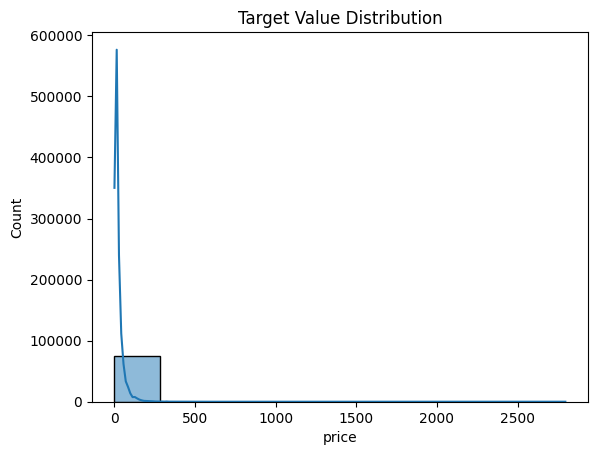

count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

target_col = "price"  # change to your actual target column name

sns.histplot(df[target_col], bins=100, kde=True)
plt.title("Target Value Distribution")
plt.show()

print(df[target_col].describe())

In [5]:
Q1 = df[target_col].quantile(0.25)
Q3 = df[target_col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[target_col] < lower_bound) | (df[target_col] > upper_bound)]
print(f"Outliers detected: {len(outliers)} / {len(df)}")

Outliers detected: 5524 / 75000


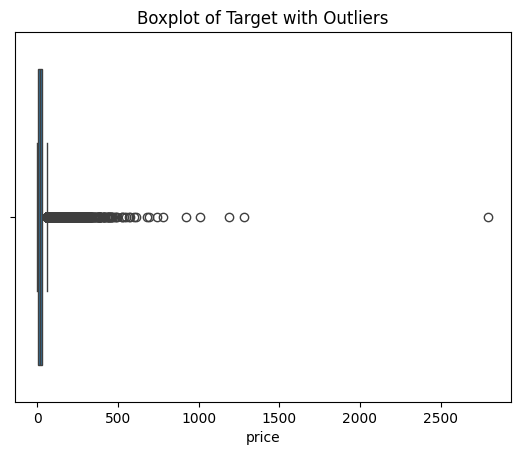

In [6]:
sns.boxplot(x=df[target_col])
plt.title("Boxplot of Target with Outliers")
plt.show()

In [8]:
import pandas as pd

df = pd.read_csv("train_clean7.csv")

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_extreme = Q1 - 3*IQR
upper_extreme = Q3 + 3*IQR

# Remove extreme outliers completely
df = df[(df['price'] >= lower_extreme) & (df['price'] <= upper_extreme)]
lower_cap = Q1 - 1.5*IQR
upper_cap = Q3 + 1.5*IQR

# Only cap price column; keep rest of row intact
df['price'] = df['price'].clip(lower=lower_cap, upper=upper_cap)

df.to_csv("train_clean7.csv", index=False)

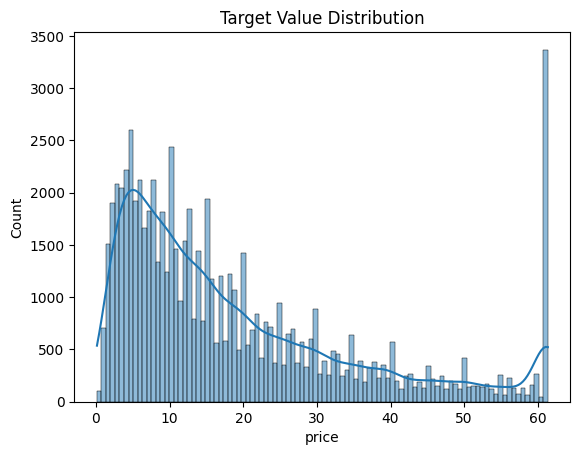

count    72762.000000
mean        19.080747
std         16.357167
min          0.130000
25%          6.590000
50%         13.727500
75%         26.707500
max         61.370000
Name: price, dtype: float64


In [9]:
target_col = "price"  # change to your actual target column name

sns.histplot(df[target_col], bins=100, kde=True)
plt.title("Target Value Distribution")
plt.show()

print(df[target_col].describe())

In [3]:
import pandas as pd
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk

# Download stopwords if not done
nltk.download('stopwords')

# === Load dataset ===
df = pd.read_csv("train_clean7.csv")

# === Clean and combine text ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

texts = df["specification"].dropna().apply(clean_text)

# === Tokenize and remove stopwords ===
stop_words = set(stopwords.words("english"))
tokens = []

for text in texts:
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    tokens.extend(words)

# === Count most common terms ===
freq = Counter(tokens)
top_terms = freq.most_common(50)  # adjust 50 → 100 for deeper insight

# === Show top 50 most frequent terms ===
for word, count in top_terms:
    print(f"{word:20s} {count}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


tea                  55283
flavor               50983
free                 49367
taste                37368
coffee               35278
natural              33192
perfect              30896
ingredients          30810
made                 29201
quality              29133
delicious            27512
water                25447
organic              24876
sugar                23123
flavors              23005
enjoy                22809
gluten               20392
candy                20331
use                  19535
chocolate            19461
sweet                19400
great                18980
snack                17982
products             17852
make                 17592
add                  17397
certified            16639
every                15557
cup                  15299
food                 14709
pack                 14698
premium              14633
rich                 14306
non                  14288
kosher               14141
fresh                14139
blend                13878
m

In [19]:
import re
import pandas as pd
import numpy as np

# ============================================================
# 1️⃣ Load the dataset
# ============================================================
df = pd.read_csv("train_clean7.csv")
print(f"Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")

# ============================================================
# 2️⃣ Initialize new columns
# ============================================================
df["weight_oz"] = np.nan
df["volume_fl_oz"] = np.nan
df["count"] = np.nan

# ============================================================
# Weight units → convert everything to ounces (oz)
# ============================================================
weight_units = {
    "oz": 1.0, "ounce": 1.0, "ounces": 1.0,
    "lb": 16.0, "lbs": 16.0, "pound": 16.0, "pounds": 16.0,
    "g": 0.03527396, "gram": 0.03527396, "grams": 0.03527396, "gramm": 0.03527396,
    "kg": 35.27396, "kilogram": 35.27396, "kilograms": 35.27396,
    "mg": 3.5274e-5, "milligram": 3.5274e-5, "milligrams": 3.5274e-5,
    "stone": 224.0, "st": 224.0,           # UK weight
    "ton": 32000.0, "tons": 32000.0        # US short ton
}

# ============================================================
# Volume units → convert everything to fluid ounces (fl oz)
# ============================================================
volume_units = {
    "fl oz": 1.0, "floz": 1.0, "fluid ounce": 1.0, "fluid ounces": 1.0, "fl ounce": 1.0,
    "ml": 0.033814, "milliliter": 0.033814, "millilitre": 0.033814, "mililitro": 0.033814,
    "l": 33.814, "ltr": 33.814, "liter": 33.814, "litre": 33.814, "liters": 33.814, "litres": 33.814,
    "gallon": 128.0, "gallons": 128.0, "gal": 128.0,
    "pt": 16.0, "pint": 16.0, "pints": 16.0,         # US pint
    "qt": 32.0, "quart": 32.0, "quarts": 32.0,     # US quart
    "cup": 8.0, "cups": 8.0,                        # US cup
    "tbsp": 0.5, "tablespoon": 0.5, "tablespoons": 0.5,
    "tsp": 0.1666667, "teaspoon": 0.1666667, "teaspoons": 0.1666667
}

count_keywords = [
    "pack", "packs", "set", "sets", "box", "boxes",
    "carton", "cartons", "bottle", "bottles",
    "can", "cans", "jar", "jars",
    "tube", "tubes", "sheet", "sheets",
    "piece", "pieces", "pcs", "count"
]

# ============================================================
# 4️⃣ Helper: Extract numeric value + unit from text
# ============================================================
def extract_value_unit(text):
    if not isinstance(text, str):
        return None, None
    text = text.lower()
    match = re.search(r'(\d+(?:\.\d+)?)\s*([a-zA-Z ]+)', text)
    if match:
        value, unit = match.groups()
        return float(value), unit.strip()
    return None, None

# ============================================================
# 5️⃣ Pass 1: Use existing `value` and `units` columns (if exist)
# ============================================================
if "value" in df.columns and "units" in df.columns:
    for i, row in df.iterrows():
        val, unit = row["value"], str(row["units"]).lower()

        # Weight units
        for wu in weight_units:
            if wu in unit:
                df.at[i, "weight_oz"] = float(val) * weight_units[wu]
                break

        # Volume units
        for vu in volume_units:
            if vu in unit:
                df.at[i, "volume_fl_oz"] = float(val) * volume_units[vu]
                break

        # Count (like 10 pack, 4 pcs)
        if "pack" in unit or "piece" in unit or "count" in unit or "pcs" in unit:
            df.at[i, "count"] = float(val)

# ============================================================
# 6️⃣ Pass 2: Fill missing from `specification` and `item_name`
# ============================================================
for idx, row in df.iterrows():
    if pd.notna(row["weight_oz"]) and pd.notna(row["volume_fl_oz"]) and pd.notna(row["count"]):
        continue  # skip filled ones

    text = f"{row.get('specification', '')} {row.get('item_name', '')}".lower()

    # --- Check weight ---
    if pd.isna(row["weight_oz"]):
        m = re.search(r'(\d+(?:\.\d+)?)\s*(g|kg|mg|lb|ounce|oz)\b', text)
        if m:
            val, unit = m.groups()
            df.at[idx, "weight_oz"] = float(val) * weight_units[unit]

    # --- Check volume ---
    if pd.isna(row["volume_fl_oz"]):
        m = re.search(r'(\d+(?:\.\d+)?)\s*(ml|l|liter|litre|gallon|fl oz|floz)\b', text)
        if m:
            val, unit = m.groups()
            df.at[idx, "volume_fl_oz"] = float(val) * volume_units[unit]

    # --- Check count ---
    if pd.isna(row["count"]):
        m = re.search(r'(?:pack|set|box|pcs|pieces|count|bottles?)\s*(?:of\s*)?(\d+)', text)
        if m:
            df.at[idx, "count"] = float(m.group(1))
        else:
            # Also handle leading numeric e.g. "12 pack cookies"
            m2 = re.search(r'(\d+)\s*(pack|pcs|pieces|count|bottles?)', text)
            if m2:
                df.at[idx, "count"] = float(m2.group(1))

# Fill remaining missing counts as 1 (future-proof way)
df["count"] = df["count"].fillna(1)

# ============================================================
# 7️⃣ Save updated file
# ============================================================
output_path = "train_clean8.csv"
df.to_csv(output_path, index=False)
print(f"Saved updated dataset → {output_path}")

# Quick stats
print("\n📊 Summary:")
print("Filled weight_oz:", df["weight_oz"].notna().sum())
print("Filled volume_fl_oz:", df["volume_fl_oz"].notna().sum())
print("Filled count:", df["count"].notna().sum())

Loaded data: 75000 rows, 8 columns
Saved updated dataset → train_clean8.csv

📊 Summary:
Filled weight_oz: 50919
Filled volume_fl_oz: 8977
Filled count: 75000


In [27]:
import pandas as pd
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk

# Download stopwords if not done
nltk.download('stopwords')

# === Load dataset ===
df = pd.read_csv("train_clean8.csv")

# === Clean and combine text ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

texts = df["specification"].dropna().apply(clean_text)

# === Tokenize and remove stopwords ===
stop_words = set(stopwords.words("english"))
tokens = []

for text in texts:
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    tokens.extend(words)

# === Count most common terms ===
freq = Counter(tokens)
top_terms = freq.most_common(50000)  # adjust 50 → 100 for deeper insight

top_terms = [word for word, count in freq.most_common(1000) if not word.isdigit()]
print(",".join(top_terms))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tea,flavor,free,taste,coffee,natural,ingredients,perfect,quality,made,delicious,water,organic,sugar,flavors,enjoy,gluten,candy,use,chocolate,sweet,great,products,snack,make,add,certified,every,cup,food,premium,pack,rich,non,fresh,kosher,blend,mix,protein,contains,one,family,serving,fruit,high,flavored,gmo,easy,bags,milk,hot,pour,bag,black,health,without,product,cold,highest,packed,favorite,freshness,terravita,per,like,experience,healthy,convenient,artificial,also,sauce,snacks,beans,whole,vegan,best,salt,treat,making,dried,good,size,low,day,roasted,minutes,spices,gift,source,oil,real,world,powder,time,spice,white,ounce,green,variety,love,unique,pitcher,home,gourmet,seasoning,ideal,box,dishes,place,crafted,ice,added,brewing,including,heat,butter,drink,rice,cookies,nuts,syrup,used,classic,calories,fat,bring,usa,friendly,ready,standards,makes,versatile,preservatives,whether,leaf,red,aroma,top,finest,point,way,pure,recipes,texture,smooth,freshly,bullet,orange,possible,dark,baking,new,colors

In [46]:
import pandas as pd
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk

# Download stopwords if not done
nltk.download('stopwords')

# === Load dataset ===
df = pd.read_csv("train_clean8.csv")

# === Clean and combine text ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

texts = df["item_name"].dropna().apply(clean_text)

# === Tokenize and remove stopwords ===
stop_words = set(stopwords.words("english"))
tokens = []

for text in texts:
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    tokens.extend(words)

# === Count most common terms ===
freq = Counter(tokens)
top_terms = freq.most_common(50000)  # adjust 50 → 100 for deeper insight

top_terms = [word for word, count in freq.most_common(1000) if not word.isdigit()]
print(",".join(top_terms))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


pack,ounce,tea,free,organic,coffee,gluten,chocolate,candy,non,mix,count,sugar,gmo,vegan,bag,bags,kosher,natural,sauce,bulk,protein,zin,whole,snack,fruit,food,black,flavor,seasoning,original,roast,box,snacks,salt,hot,flavored,sweet,white,loose,powder,dark,per,made,green,butter,blend,premium,low,bottle,keto,ground,water,gourmet,pound,rice,case,drink,red,spice,milk,friendly,medium,oil,ounces,dried,vanilla,roasted,certified,beans,bars,pods,variety,fresh,cup,chips,pasta,chicken,honey,cookies,gift,bar,baking,syrup,peanut,single,jar,cream,foods,perfect,pure,strawberry,healthy,size,great,raw,lemon,soup,coconut,zero,grain,cheese,cereal,lbs,high,flavors,pepper,cinnamon,juice,wrapped,pounds,bean,garlic,nut,leaf,orange,apple,serve,caramel,energy,spicy,cups,individually,herbal,packs,ginger,added,nuts,instant,breakfast,classic,rich,caffeine,beef,keurig,cooking,chili,blue,fiber,light,sea,plant,live,cans,cherry,bottles,corn,seeds,based,cake,raspberry,dairy,party,boxes,decaf,style,popcorn,almond,usa,cr

In [52]:
import pandas as pd

# === Detailed category dictionary (duplicates merged) ===
detailed_categories = {
    "tea": ["tea", "teabags", "oolong", "green", "herbal", "chai", "matcha", "brewing", "yerba", "caffeine"],
    "coffee": ["coffee", "espresso", "arabica", "cappuccino", "latte", "brewing", "keurig"],
    "soft_drink": ["soda", "cola", "sparkling", "juice", "energy", "iced", "cold", "smoothies", "cider"],
    "juice": ["juice", "lemonade", "orange", "apple", "fruit", "berry", "tropical", "grape", "citrus"],
    "sweets": ["chocolate", "candy", "chocolates", "bars", "brownie", "lollipops", "oreo", "toffee", "chewy", "lollipop"],
    "cookies": ["cookies", "biscuit", "biscuits", "wafer", "shortbread", "muffin", "cupcake", "cracker"],
    "protein_health": ["protein", "supplement", "chia", "xylitol", "unsweetened", "plant", "pistachio", "superfood", "wellness"],
    "spices": ["spice", "spices", "seasoning", "marinades", "saffron", "cumin", "garlic", "pepper", "herb", "curry", "seasoned"],
    "milk": ["milk", "cream", "butter", "parmesan", "cheese", "yogurt", "dairy"],
    "dry_fruits": ["nuts", "almond", "cashews", "peanuts", "pistachio", "trail", "mix", "seeds", "nutty"],
    "grains": ["grains", "cereal", "oats", "semolina", "barley", "quaker", "breakfast"],
    "noodles": ["pasta", "noodles", "spaghetti", "ramen", "macaroni"],
    "cake": ["cake", "pastry", "donut", "brownie", "cupcake", "muffin"],
    "fruits": ["fruit", "apple", "orange", "lemon", "berry", "banana", "grape", "strawberry", "kiwi", "pineapple", "mango"],
    "vegetables": ["vegetable", "veggies", "tomato", "onion", "corn", "potato", "broccoli", "peppers"],
    "non_veg": ["meat", "beef", "chicken", "pork", "turkey", "eggs", "poultry", "bacon", "sausage"],
    "crispy": ["chips", "crispy", "puffs", "crisps", "snacks", "popcorn"],
    "sauces": ["sauce", "sauces", "ketchup", "mustard", "vinegar", "dressing", "salsa", "paste", "condensed", "broth"],
    "gifts": ["gift", "multi", "canister", "party", "holiday", "christmas", "valentine"],
    "spicy": ["spicy", "chili", "pepper", "masala", "peri peri"],
    "savory": ["salted", "herb", "garlic", "onion", "tangy"]
}

# === Function to extract categories ===
def extract_types(text):
    text = str(text).lower()
    matched_types = []
    for category, keywords in detailed_categories.items():
        for kw in keywords:
            if kw in text:
                matched_types.append(category)
                break
    return " ".join(matched_types) if matched_types else "other"

# === Main processing function ===
def process_csv(input_csv, output_csv):
    df = pd.read_csv(input_csv)

    # 'type' from item_name
    df['type'] = df['item_name'].apply(extract_types)

    # 'related' from specification
    df['related'] = df['specification'].apply(extract_types)

    # Save new CSV
    df.to_csv(output_csv, index=False)
    print(f"✅ Processed CSV saved to {output_csv}")

    # Count occurrences for type
    type_counts = {}
    for types in df['type']:
        for t in types.split():
            type_counts[t] = type_counts.get(t, 0) + 1

    print("\n📊 Number of rows under each TYPE:")
    for t, count in sorted(type_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{t:20s}: {count}")

    # Count occurrences for related
    related_counts = {}
    for rels in df['related']:
        for r in rels.split():
            related_counts[r] = related_counts.get(r, 0) + 1

    print("\n📊 Number of rows under each RELATED:")
    for r, count in sorted(related_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{r:20s}: {count}")

# === Usage ===
input_csv = "train_clean8.csv"
output_csv = "train_clean9.csv"
process_csv(input_csv, output_csv)


✅ Processed CSV saved to train_clean9.csv

📊 Number of rows under each TYPE:
other               : 14638
fruits              : 11384
tea                 : 10599
soft_drink          : 10392
juice               : 10261
sweets              : 9577
spices              : 9140
dry_fruits          : 8919
milk                : 8151
sauces              : 6040
coffee              : 5440
vegetables          : 4959
protein_health      : 4596
crispy              : 4593
savory              : 4248
spicy               : 4008
non_veg             : 3653
gifts               : 3644
cookies             : 3173
cake                : 2516
grains              : 2498
noodles             : 1966

📊 Number of rows under each RELATED:
soft_drink          : 19892
milk                : 19261
other               : 17857
tea                 : 16439
fruits              : 16023
juice               : 15817
dry_fruits          : 15738
spices              : 15278
protein_health      : 12914
vegetables          : 12680
sweets

In [53]:
nutritional_dict = {
    "protein": ["protein", "whey", "soy", "lentil", "chickpea", "egg", "meat", "milk"],
    "fiber": ["fiber", "multigrain", "wholegrain", "oats", "bran"],
    "sugar": ["sugar", "sweet", "honey", "syrup", "caramel", "candy", "chocolate"],
    "fat": ["butter", "oil", "cheese", "ghee", "cream", "nut", "almond", "cashew"],
    "carbs": ["rice", "pasta", "bread", "noodle", "cereal", "corn", "flour"],
    "vitamins": ["fortified", "enriched", "vitamin", "omega", "probiotic"],
    "low_sugar": ["sugar free", "no sugar", "zero sugar"],
    "low_fat": ["low fat", "fat free", "skimmed"]
}
df = pd.read_csv("train_clean9.csv")
def extract_tags(text, dictionary):
    tags = []
    text = str(text).lower()
    for tag, keywords in dictionary.items():
        for kw in keywords:
            if kw in text:
                tags.append(tag)
                break
    return " ".join(tags) if tags else ""
df["nutritional_value"] = df["item_name"].apply(lambda x: extract_tags(x, nutritional_dict)) + " " + \
                          df["specification"].apply(lambda x: extract_tags(x, nutritional_dict))
df.to_csv("train_clean9.csv", index=False)

print("Added 'nutritional_value' column!")

Added 'nutritional_value' column!


In [54]:
import pandas as pd
import re

# === Load CSV ===
df = pd.read_csv("train_clean9.csv")  # your updated CSV

# Replace commas and multiple spaces with single space
df['type'] = df['type'].apply(lambda x: re.sub(r'[,\s]+', ' ', str(x)).strip())
df['related'] = df['related'].apply(lambda x: re.sub(r'[,\s]+', ' ', str(x)).strip())
df['nutritional_value'] = df['nutritional_value'].apply(lambda x: re.sub(r'[,\s]+', ' ', str(x)).strip())

# Save the cleaned CSV
df.to_csv("train_clean9.csv", index=False)
print("Saved CSV with cleaned type column")

Saved CSV with cleaned type column
